"""
Homework version

Main variables and their explanations
phasepicks: np.array((npicks, 4))
4 columns are: station x, station y, phasetype (1 for P, 2 for S), traveltime(demean)

mean_arrival_time

Task:
1. find a function that can convert latitude, longitude to x,y in km
2.
"""

In [2]:
# reload the module to get the latest changes
import sys
sys.path.append('./my_funcs')
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from tqdm.notebook import tqdm
from my_funcs.step1_funcs import *
# # print the list of functions in step1_funcs.py, only that are defined in this file
# func_list = [func for func in dir() if callable(eval(func))]
# for f in func_list: print(f)

######### Part 1. Read phase picks #########
# get a list of all the event id folders
event_paths = glob.glob("../data/eq_data/*")
# Filter only directories
event_paths = [path for path in event_paths if os.path.isdir(path)]
# Extract event IDs from the directory names
event_ids = [os.path.basename(path) for path in event_paths]
event_ids = ['nc73201181']
# Read earthquake data
eqdf = pd.read_csv("../data/above_slab_eq_df.csv", parse_dates=["time"])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
event_id = 'nc73201181'
folder_station = f'../data/eq_data/{event_id}'
filename_picks = f'{folder_station}/event_picks.txt'
print(event_ids, filename_picks)

######### Part 1. Read phase picks #########
# read phase picks file
phasepicks, mean_arrival_time = read_phase_picks(filename_picks, folder_station)
npick = phasepicks.shape[0]

######### Part 2. Points and value for P/S traveltime interpolation #########
P_points, P_value = get_traveltime_points_value('./traveltime_point_values/tt_MTJ_comploc_p')
S_points, S_value = get_traveltime_points_value('./traveltime_point_values/tt_MTJ_comploc_s')

######### define grids #########
lat_range = np.arange(39.5, 41.5, 0.02)
lon_range = np.arange(-124.5, -123.0, 0.02)
dep_range = np.arange(0, 40, 0.5)
nx, ny, nz = len(lon_range), len(lat_range), len(dep_range)

event_df = eqdf[eqdf["id"] == event_id]
elat, elon, edep, t_origin = event_df["latitude"].values[0], event_df["longitude"].values[0], event_df["depth"].values[0], UTCDateTime(pd.to_datetime(event_df["time"].values[0]))

grids_lat, grids_lon, grids_z = np.zeros((nx*ny*nz, )), np.zeros((nx*ny*nz, )), np.zeros((nx*ny*nz, ))
for grid_index in range(0, nx*ny*nz):
    lon_index, lat_index, dep_index = np.unravel_index(grid_index, (nx, ny, nz)) 
    grids_lon[grid_index] = lon_range[lon_index]
    grids_lat[grid_index] = lat_range[lat_index]
    grids_z[grid_index] = dep_range[dep_index]
grid_x, grid_y = convert_lat_lon_to_xy(grids_lat, grids_lon)

distance1 = np.zeros((nx*ny*nz, npick))
# traveltime = np.zeros((nx*ny*nz, npick))
# mean_traveltime = np.zeros((nx*ny*nz, ))

######### Part 3. Interpolate P/S traveltime #########
######### using multiprocessing #########
import ray

# Initialize Ray (should be done once per notebook)
ignore_reinit_error=True
# ray.init()

# Define your worker function
@ray.remote
def worker(ipick, phasepicks, grid_x, grid_y, P_points, P_value, grids_z):
  distance = np.sqrt((phasepicks[ipick, 0] - grid_x)**2 +
                     (phasepicks[ipick, 1] - grid_y)**2)
  xi = np.array([distance, grids_z]).T # .T is transpose, means (2, 1) -> (1, 2)
  if phasepicks[ipick, 2] == 1:
    return griddata(P_points, P_value, xi, method='linear')
  else:
    return None

# Set number of workers (ideally, less than CPU cores)
n_workers = max(1, 8)

# Submit tasks to Ray actors
futures = [worker.remote(ipick, phasepicks, grid_x, grid_y, P_points, P_value, grids_z) for ipick in range(npick)]

# Collect results from multiple processes
traveltime = ray.get(futures)

# Remove None values (picks with incompatible phase type)
traveltime = [result for result in traveltime if result is not None]

# Convert to numpy array
traveltime = np.array(traveltime).T

# shutdown Ray (otherwise, it will keep running in the background)
ray.shutdown()

print(traveltime)#.shape, distance1.shape)

######### End of multiprocessing #########

['nc73201181'] ../data/eq_data/nc73201181/event_picks.txt


2023-12-17 00:45:48,591	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


[[19.26353319 19.93752839 18.95532937 ... 22.64832553         nan
  19.89936694]
 [18.98973319 19.66372839 18.68152937 ... 22.37426113         nan
  19.62556694]
 [18.75243319 19.42642839 18.44425825 ... 22.13676113         nan
  19.38826694]
 ...
 [        nan         nan         nan ...         nan 10.06585299
          nan]
 [        nan         nan         nan ...         nan 10.09650412
          nan]
 [        nan         nan         nan ...         nan 10.12756503
          nan]]


  0%|          | 0/34 [00:00<?, ?it/s]

Best location and orign time estimates
lat:40.26, lon:-124.46, dep:39.50
Origin time:2019-06-23T03:53:01.682014Z


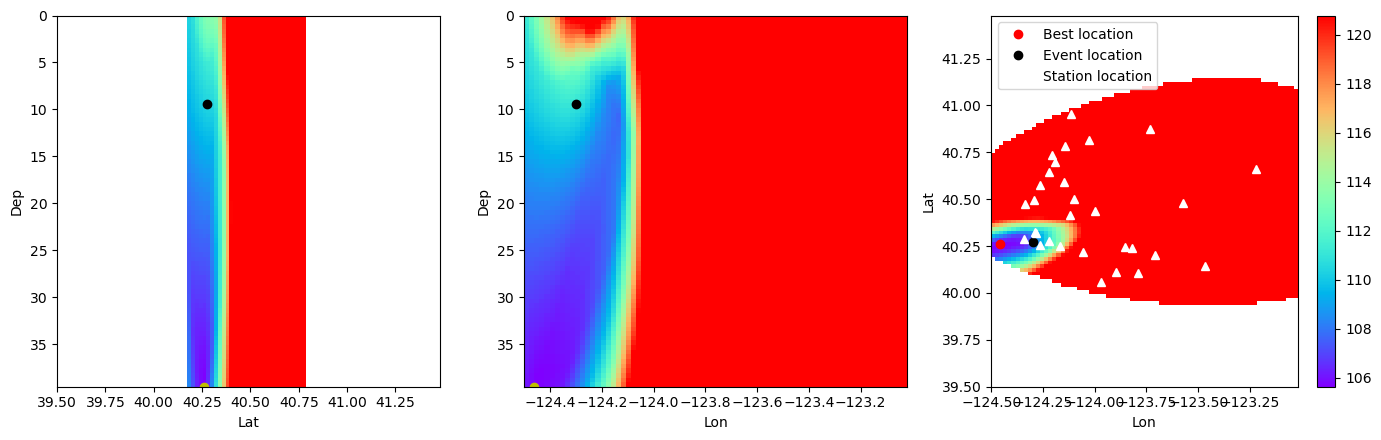

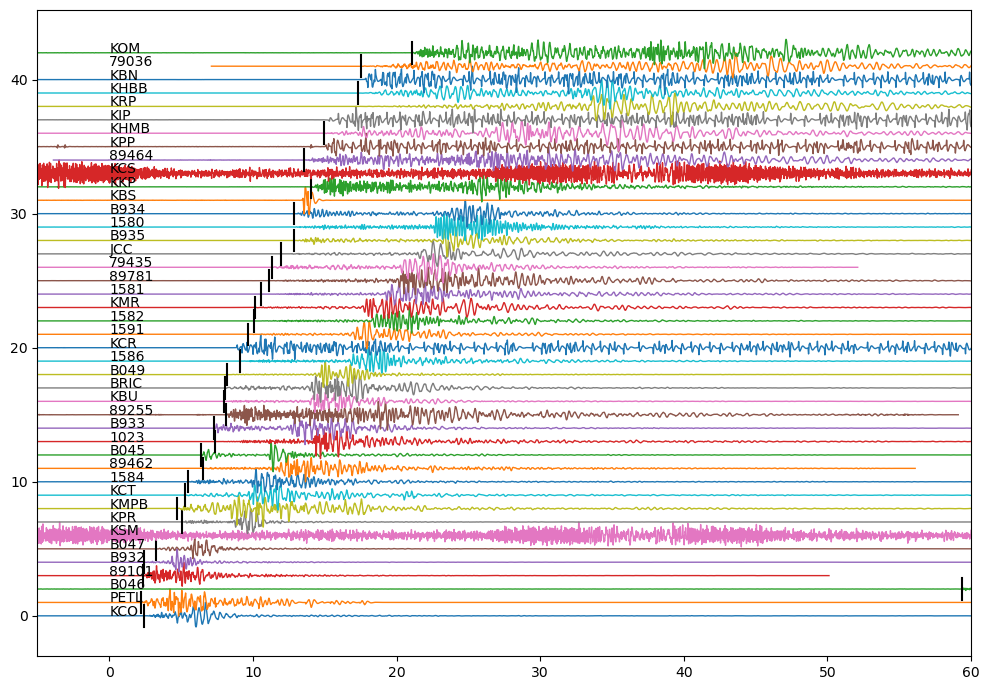

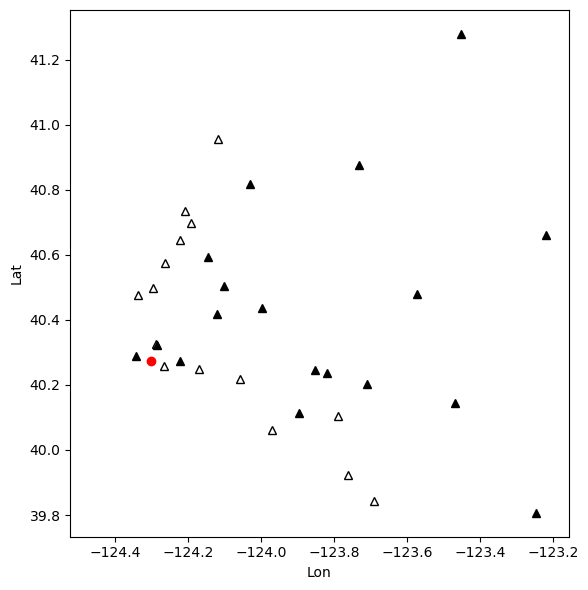

In [66]:
for event_id in event_ids:
    
    folder_station = f'../data/eq_data/{event_id}'
    filename_picks = f'{folder_station}/event_picks.txt'
    print(event_ids, filename_picks)

    ######### Part 1. Read phase picks #########
    # read phase picks file
    phasepicks, mean_arrival_time = read_phase_picks(filename_picks, folder_station)
    npick = phasepicks.shape[0]

    ######### Part 2. Points and value for P/S traveltime interpolation #########
    P_points, P_value = get_traveltime_points_value('./traveltime_point_values/tt_MTJ_comploc_p')
    S_points, S_value = get_traveltime_points_value('./traveltime_point_values/tt_MTJ_comploc_s')

    ######### define grids #########
    lat_range = np.arange(39.5, 41.5, 0.02)
    lon_range = np.arange(-124.5, -123.0, 0.02)
    dep_range = np.arange(0, 40, 0.5)
    nx, ny, nz = len(lon_range), len(lat_range), len(dep_range)

    event_df = eqdf[eqdf["id"] == event_id]
    elat, elon, edep, t_origin = event_df["latitude"].values[0], event_df["longitude"].values[0], event_df["depth"].values[0], UTCDateTime(pd.to_datetime(event_df["time"].values[0]))

    grids_lat, grids_lon, grids_z = np.zeros((nx*ny*nz, )), np.zeros((nx*ny*nz, )), np.zeros((nx*ny*nz, ))
    for grid_index in range(0, nx*ny*nz):
        lon_index, lat_index, dep_index = np.unravel_index(grid_index, (nx, ny, nz)) 
        grids_lon[grid_index] = lon_range[lon_index]
        grids_lat[grid_index] = lat_range[lat_index]
        grids_z[grid_index] = dep_range[dep_index]
    grid_x, grid_y = convert_lat_lon_to_xy(grids_lat, grids_lon)


    ######### loops #########
    distance = np.zeros((nx*ny*nz, npick))
    traveltime = np.zeros((nx*ny*nz, npick))
    mean_traveltime = np.zeros((nx*ny*nz, ))

    # loop over all the picks
    for ipick in tqdm(range(0, npick)):
        
        distance[:, ipick] = np.sqrt((phasepicks[ipick, 0] - grid_x)**2 +
                                    (phasepicks[ipick, 1] - grid_y)**2)
        xi = np.array([distance[:, ipick], grids_z]).T # (ngrid, 2) array of distance and depth

        if phasepicks[ipick, 2] == 1:
            traveltime[:, ipick] = griddata(P_points, P_value, xi, method='linear')
            # print(traveltime[:, ipick])
        else:
            continue
            # traveltime[:, ipick] = griddata(S_points, S_value, xi, method='linear')

    # Remove mean for traveltime array
    mean_traveltime = np.zeros((nx*ny*nz, ))
    traveltime_demean = np.zeros((nx*ny*nz, npick))
    misfit = np.zeros((nx*ny*nz, ))

    for grid_index in range(0, nx*ny*nz):
        traveltime_demean[grid_index, :] = traveltime[grid_index, :] - np.mean(traveltime[grid_index, :])
        misfit[grid_index] = get_misfit(traveltime_demean[grid_index, :], phasepicks[:,3])
        mean_traveltime[grid_index] = np.mean(traveltime[grid_index, :])

    min_index = np.nanargmin(misfit) # index of the minimum misfit, nanargmin ignores nan values
    min_index_x, min_index_y, min_index_z = np.unravel_index(min_index, (nx, ny, nz))
    best_lon, best_lat, best_dep = lon_range[min_index_x], lat_range[min_index_y], dep_range[min_index_z]
    origin_time = mean_arrival_time - mean_traveltime[min_index]
    print('Best location and orign time estimates')
    print('lat:{:.2f}, lon:{:.2f}, dep:{:.2f}'.format(best_lat, best_lon, best_dep))
    print('Origin time:{}'.format(origin_time))
    ################### plot misfit ################### 
    if not os.path.exists(f'{folder_station}/png'):
        os.mkdir(f'{folder_station}/png')

    slon, slat = get_sta_lat_lon(filename_picks, folder_station)
    misfit_matrix = np.reshape(misfit, (nx, ny, nz))
    vmin, vmax = np.nanmin(misfit), np.nanmax(misfit)
    vmax = (vmax - vmin) * 0.1 + vmin
    cmap = 'rainbow'

    fig = plt.figure(figsize=(14, 4.5))

    # N-S cross section
    ax = fig.add_subplot(1, 3, 1)
    i = min_index_x
    ax.imshow(
        misfit_matrix[i, :, :].T, 
        vmin=vmin, vmax=vmax, 
        origin='upper', cmap=cmap,
        extent=(lat_range[0], lat_range[-1], dep_range[-1], dep_range[0]), 
        aspect='auto'
        )
    # plot the best location
    ax.plot(grids_lat[min_index], grids_z[min_index], 'o', color='y')
    # plot the event location (given)
    ax.plot(elat, edep, 'o', color='black', label='Event given location')
    ax.set_xlabel('Lat')
    ax.set_ylabel('Dep')

    # E-W cross section
    ax = fig.add_subplot(1, 3, 2)
    i = min_index_y # index of the best lat
    ax.imshow(misfit_matrix[:, i, :].T, vmin=vmin, vmax=vmax, origin='upper', cmap=cmap,
            extent=(lon_range[0], lon_range[-1], dep_range[-1], dep_range[0]), aspect='auto')
    # plot the best location          
    ax.plot(grids_lon[min_index], grids_z[min_index], 'o', color='y')
    # plot the event location (given)
    ax.plot(elon, edep, 'o', color='black')
    ax.set_xlabel('Lon')
    ax.set_ylabel('Dep')

    # Map view 
    ax = fig.add_subplot(1, 3, 3)
    i = min_index_z
    im = ax.imshow(misfit_matrix[:, :, i].T, vmin=vmin, vmax=vmax, origin='lower', cmap=cmap,
            extent=(lon_range[0], lon_range[-1], lat_range[0], lat_range[-1]), aspect='auto')
    ax.plot(grids_lon[min_index], grids_lat[min_index], 'o', color='r') # best location
    ax.plot(elon, elat, 'o', color='black') # event location
    ax.plot(slon, slat, '^', color='w') # station location
    plt.colorbar(im)
    ax.set_xlabel('Lon')
    ax.set_ylabel('Lat')
    ax.legend(['Best location', 'Event location', 'Station location'])
    plt.tight_layout()
    # fig.savefig(f'{folder_station}/png/Misfit.png')
    plt.show()



    ################### plot waveform and picks ################### 
    phaselist = get_phasepicks_list(filename_picks)
    stanames, distances = get_sta_dist(folder_station, elat, elon)
    index = np.argsort(distances)
    mseed = f'{folder_station}/event_waveforms.mseed'
    st = read(mseed)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(1,1,1)

    for i in range(0, len(stanames)):
        j = index[i]
        sta = stanames[j]
        temp_st = st.select(station=sta)
        chans = []
        for k in range(0, len(temp_st)):
            chans.append(st[k].stats.channel)
            
        Z_channel = -1
        for k in range(0, len(chans)):
            if chans[k][-1] == 'Z':
                Z_channel = k
                break
        if Z_channel < 0:
            Z_channel = 0

        tr = temp_st[Z_channel]
        tr.detrend('demean')
        tr.filter('bandpass', freqmin=2, freqmax=20)
        tr.taper(0.05)
        tr.data = tr.data/np.max(tr.data)

        t = (tr.stats.starttime-t_origin) + np.arange(0, tr.stats.npts)/tr.stats.sampling_rate # time array
        ax.plot(t, tr.data+i, lw=1) # plot waveform

        if '{}-P'.format(sta) in phaselist:

            dt = phaselist['{}-P'.format(sta)]-t_origin # time difference between origin time and P arrival time
            ax.plot([dt, dt], [i-0.8, i+0.8],'k') # plot vertical line black bet
        if '{}-S'.format(sta) in phaselist:
            dt = phaselist['{}-S'.format(sta)]-t_origin
            ax.plot([dt, dt], [i-0.8, i+0.8],'k')
        ax.text(0, i, sta)

    ax.set_xlim([-5, 60])
    plt.tight_layout()
    # fig.savefig('png/picks.png')
    plt.show()


    ################### plot polarity ################### 
    polarities, stanames = get_polarity(filename_picks, folder_station)
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(grids_lon[min_index], grids_lat[min_index], 'o', color='w') # best location
    ax.plot(elon, elat, 'o', color='r')
    for i in range(0, len(stanames)):
        if polarities[i, 0] == 1:
            ax.plot(polarities[i, 2], polarities[i, 1], '^', color='k', mec='k') # plot polarity
        elif polarities[i, 0] == -1:
            ax.plot(polarities[i, 2], polarities[i, 1], '^', color='w', mec='k')
    ax.set_xlabel('Lon')
    ax.set_ylabel('Lat')
    plt.tight_layout()
    # fig.savefig('png/Polarity.png')
    plt.show()